## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-outdoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_diagonal_wavelet_outdoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/outdoor/wavelet/diagonal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 2446,
 3: 9784,
 4: 39136,
 5: 156544,
 6: 626176,
 7: 2504704,
 8: 10018816,
 9: 40075264}

Running 12760 CDFs


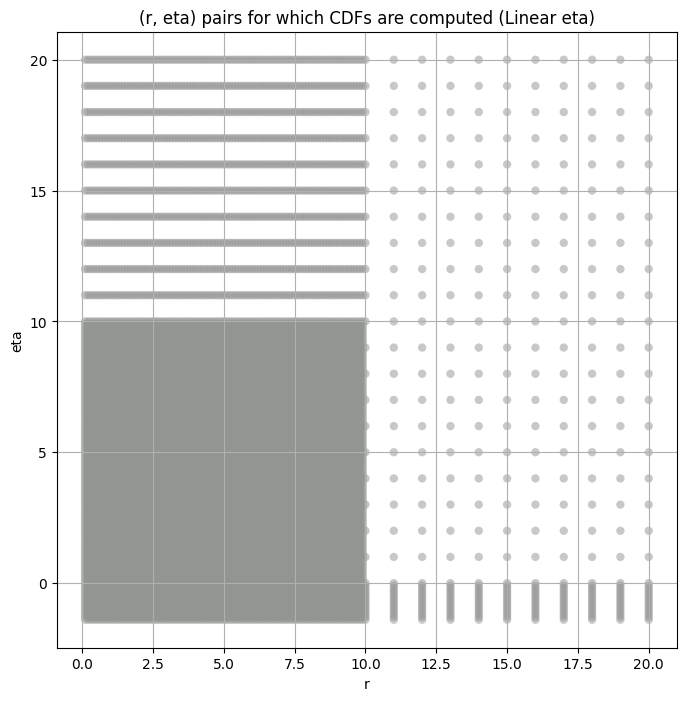

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1353.190300  1245.670900  1465.388900   0.434779    0.144766   
3       327.517880   311.696040   344.012240   1.583804    1.274782   
4        68.147350    63.903770    72.760056   4.318310    2.980371   
5        13.558892    12.578346    14.675803   6.925879    4.667317   
6         2.634974     2.408211     2.941564  12.295376    6.609304   
7         0.536970     0.482075     0.646513  28.076822    8.176512   
8         0.155016     0.136908     0.197966  46.127980    9.823513   
9         0.047454     0.041207     0.060932  54.854145   13.487100   

       kurt_upper  total_samples  
layer                             
2        0.749931         2446.0  
3        1.950991         9784.0  
4        7.683027        39136.0  
5       16.993916       156544.0  
6       44.604836       626176.0  
7      160.379710      2504704.0  
8      257.993900     10018816.0  
9      273.324620     40075264.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1353.190300    1353.190308     1155.870850     1031.261475   
3       327.517880     327.517883      304.221191      288.780243   
4        68.147350      68.147346       65.227028       63.469982   
5        13.558892      13.558892       13.171043       12.938088   
6         2.634974       2.634974        2.530236        2.474373   
7         0.536970       0.536970        0.507871        0.494842   
8         0.155016       0.155016        0.144787        0.140660   
9         0.047454       0.047454        0.043801        0.042288   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          931.084473       849.583801       714.612000       602.919495   
3          275.695343       264.358398       245.124603       228.826965   
4           62.045425        60.783890        58.525414        56.534889   
5           12.743633        12.572252        12.269126        12.001592   
6            2.427869         2.386727         2.315599         2.254952   
7            0.484178         0.474931         0.459005         0.445340   
8            0.137289         0.134362         0.129338         0.125043   
9            0.041062         0.040003         0.038197         0.036667   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           511.646820       436.108704       372.859406       227.517822  
3           214.385681       201.397095       189.715622       160.706055  
4            54.762878        53.166443        51.689186        47.819920  
5            11.757642        11.532422        11.321332        10.765843  
6             2.200647         2.150936         2.104986         1.983879  
7             0.433212         0.422201         0.412094         0.385761  
8             0.121244         0.117819         0.114684         0.106559  
9             0.035325         0.034123         0.033031         0.030235

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.01416900310859981 1353.1903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.023862927032737624 1155.8708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.034045844061911135 1031.2615


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.04321545537827676 931.0845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.05359045581088395 849.5838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.07303572231074862 714.612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.09312813716341284 602.9195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.11183695706296226 511.64682


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.12904879264923508 436.1087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.14550110105808756 372.8594


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.19437978063903272 227.51782
Number of samples: 2446, Without approximation : 2446.0


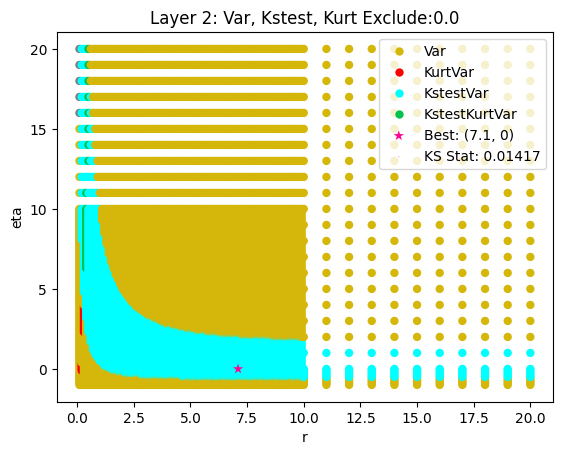

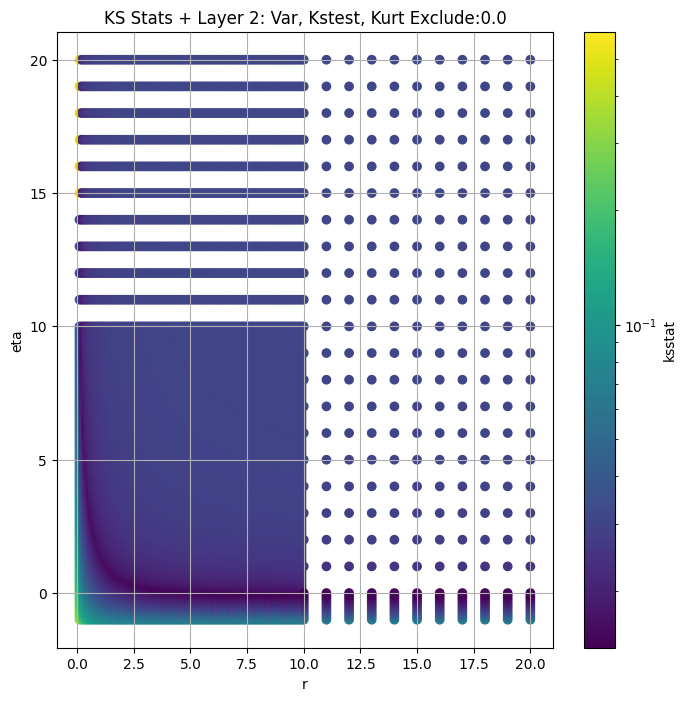

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.006291815558071456 327.51788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.009588182188469907 304.2212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01166690933779202 288.78024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01401183604469125 275.69534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.01697120033987576 264.3584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.02281016591701135 245.1246


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.028552113981401672 228.82697


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.033869712918420225 214.38568


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.03912462934719674 201.3971


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.044119025320199845 189.71562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.05866239181399335 160.70605
Number of samples: 9784, Without approximation : 9784.0


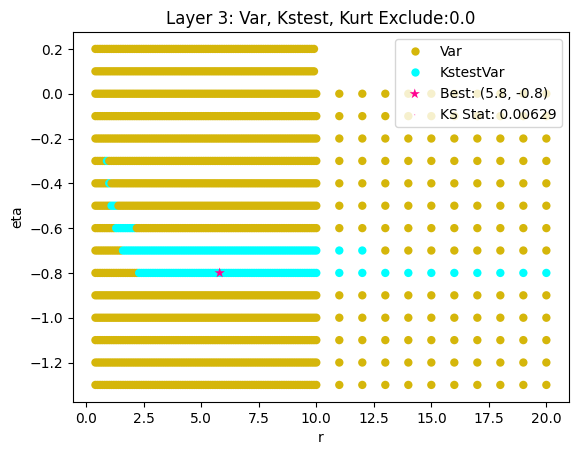

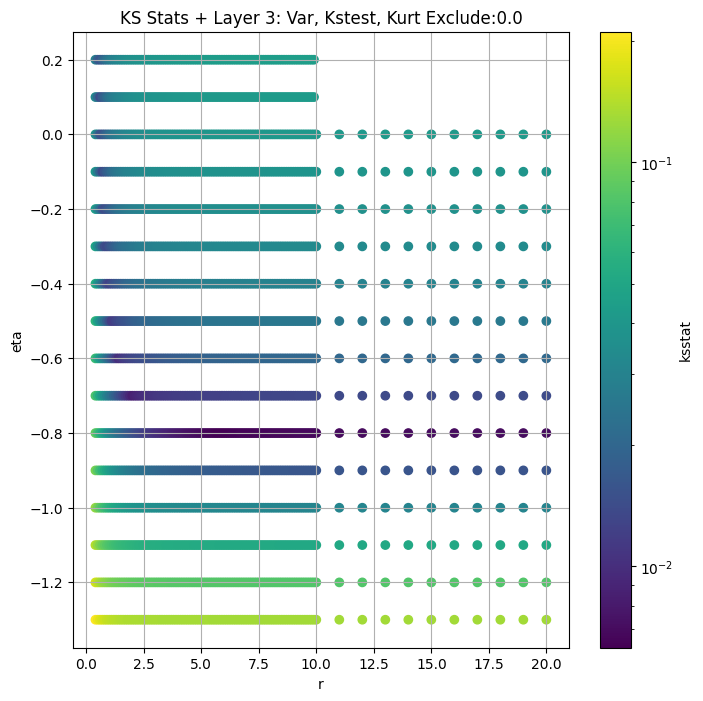

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0039049636432911816 68.14735


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.004037983040090398 65.22703


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.004294567292439377 63.469982


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0043208996210458706 62.045425


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.004738006906716771 60.78389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006142974622348776 58.525414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.007973121076593426 56.53489


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.009883234072985858 54.76288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01206213215881935 53.166443


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.013591954939552009 51.689186


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.018231058814180745 47.81992
Number of samples: 39136, Without approximation : 39136.0


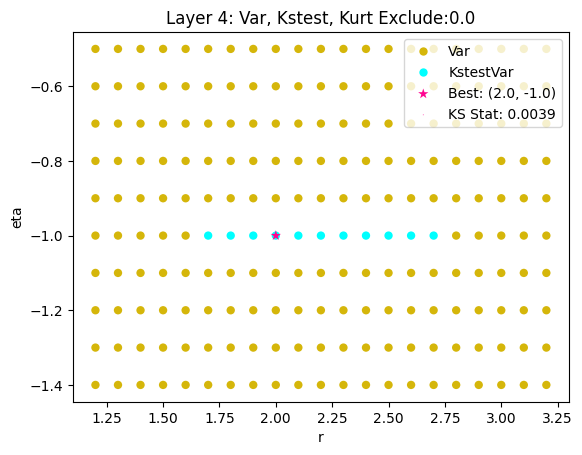

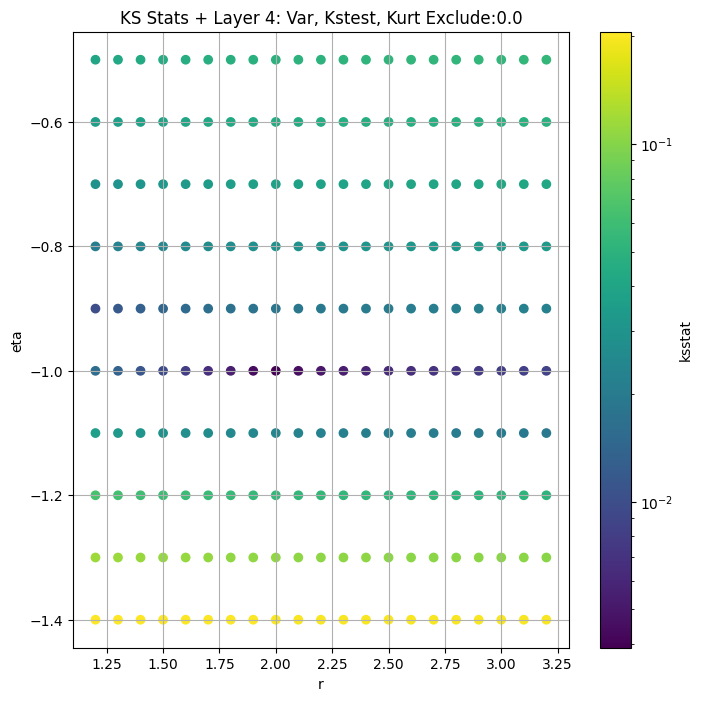

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.004219574164632589 13.558892


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.005988594855344642 13.171043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.006639362539277716 12.938088


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0059407915690344315 12.743633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006371435617238852 12.572252


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006876538087734474 12.269126


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006700366132368685 12.001592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.0066330217188835805 11.757642


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006580732922097571 11.532422


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006536975810215173 11.321332


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007896675306774525 10.765843
Number of samples: 100000, Without approximation : 156544.0


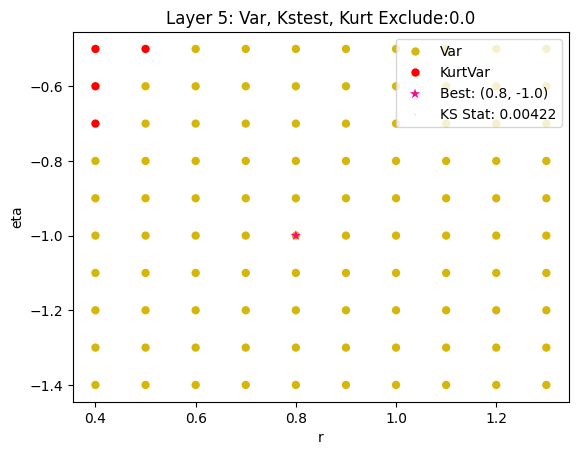

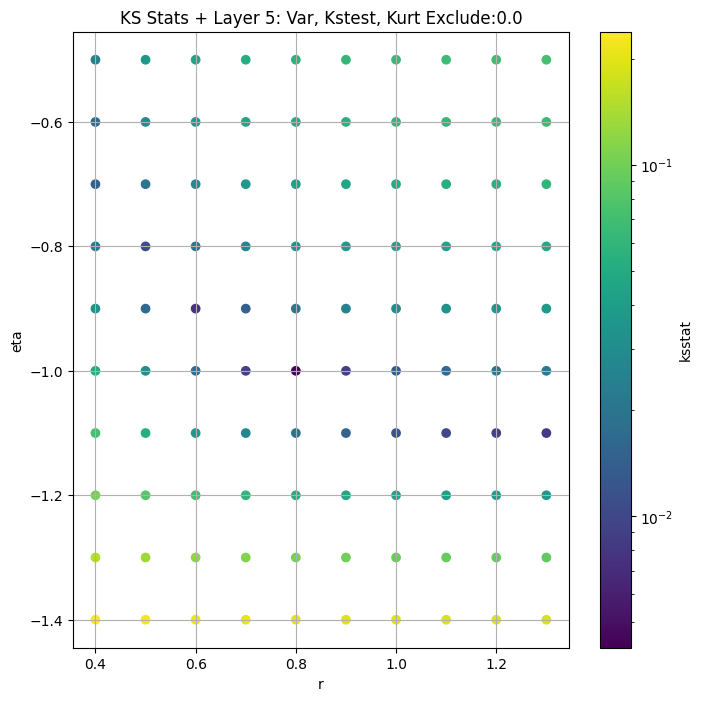

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.012166500696895954 2.6349738


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.012399820887562363 2.530236


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.012922278775295615 2.4743733


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.012983712376053225 2.4278686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01284506513976491 2.386727


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.012598705314932679 2.315599


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.012381941716117506 2.2549522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.012181466137788033 2.2006466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.012264118299683546 2.1509361


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.012913806421412932 2.1049864


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.013113541769839587 1.9838786
Number of samples: 100000, Without approximation : 626176.0


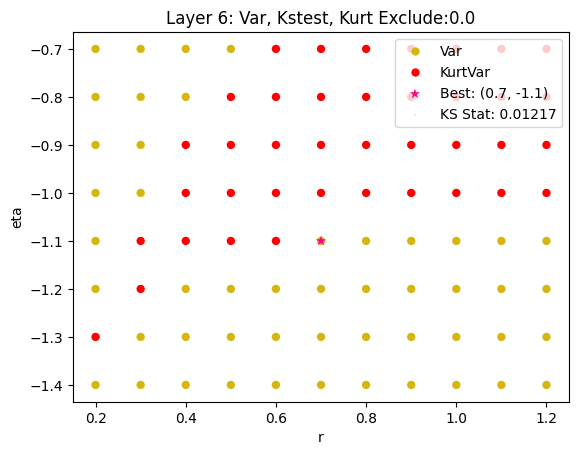

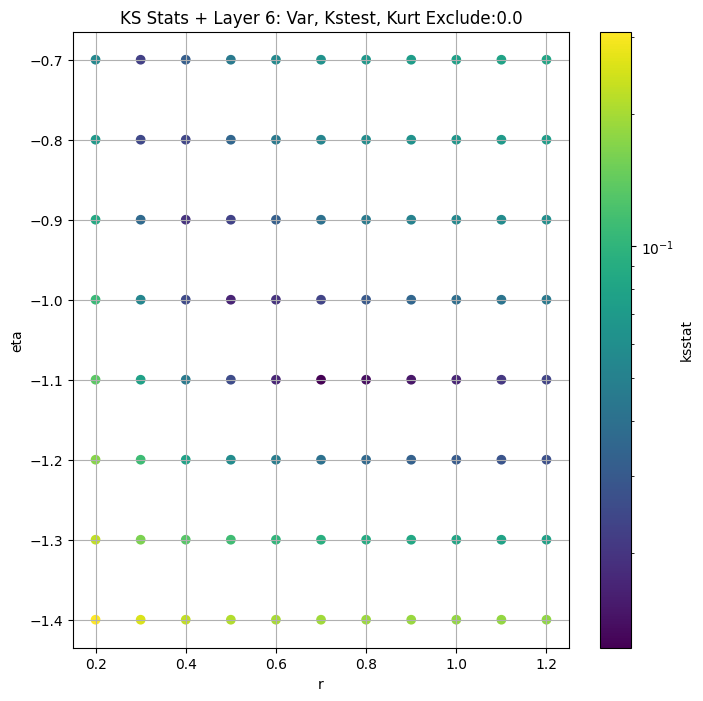

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.014303655212672073 0.53696954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.013423842466606994 0.50787103


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.014218020011428578 0.49484178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.013994883499540645 0.48417774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.01368990796357733 0.47493118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.014182340687072803 0.45900467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.013732010051603738 0.4453402


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.014054391161618662 0.43321192


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.013749063084323998 0.4222012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.014056343232374813 0.412094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.013675205863106221 0.38576072
Number of samples: 100000, Without approximation : 2504704.0


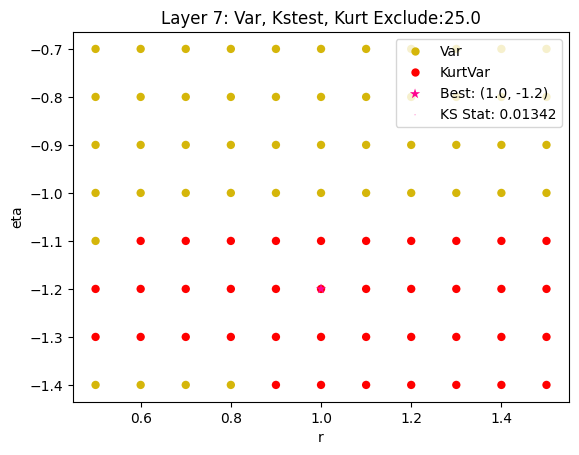

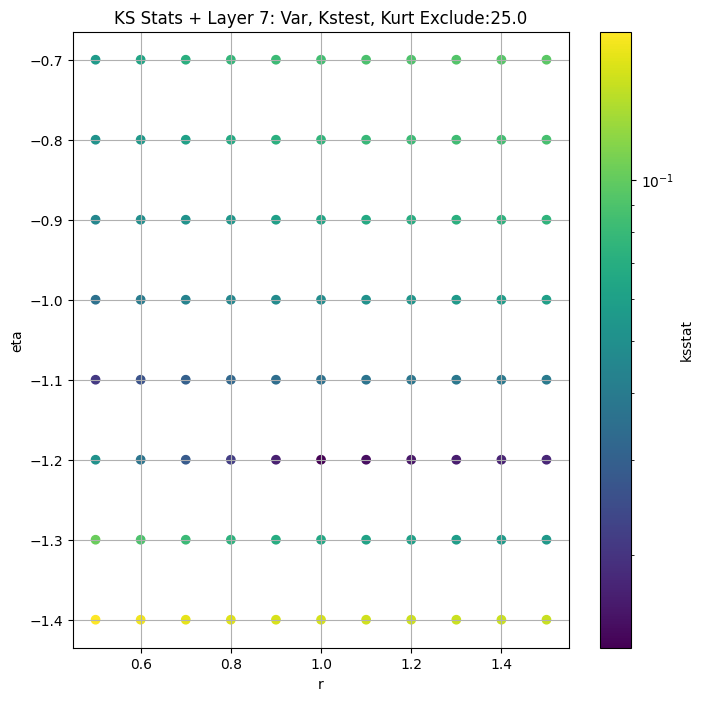

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.011942957652716357 0.15501633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010338903506461494 0.14478691


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.009623422673691151 0.14065988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.009018884354856038 0.13728912


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.008483515533780905 0.13436213


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009597920232340962 0.12933789


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.01095853106637712 0.12504265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.010651175337568541 0.12124395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.010810512938502548 0.11781887


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.010677973662755136 0.11468448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010379367818923901 0.106558785
Number of samples: 100000, Without approximation : 10018816.0


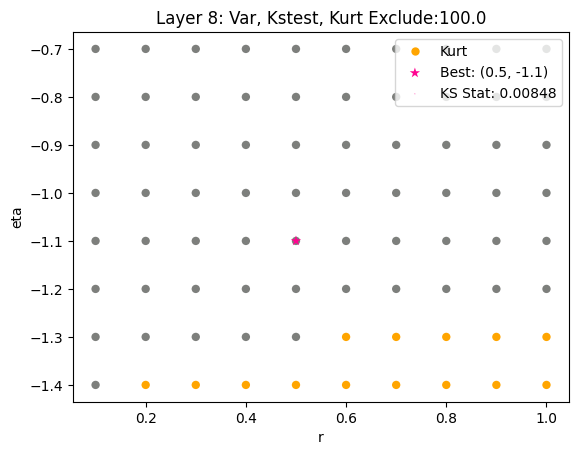

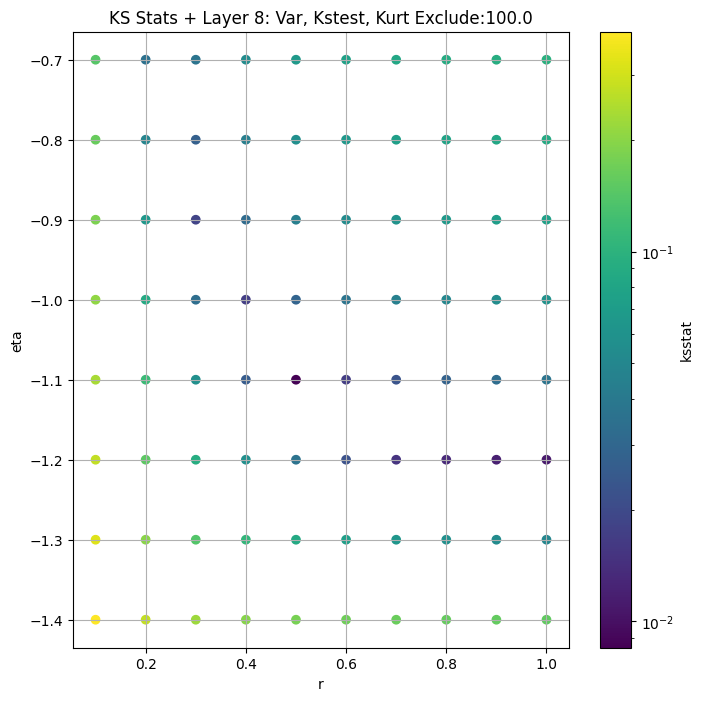

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.02039567675630785 0.04745376


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.02230129966057426 0.043800764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.0218163637075946 0.0422881


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.020373025898688113 0.041062105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.02027580024921527 0.040003136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.022143149714020982 0.038196944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.02380695362182572 0.036666818


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.023632516029690354 0.03532497


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.021937242759505482 0.034123033


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.020342366725118854 0.0330312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.02054426944224541 0.03023537
Number of samples: 100000, Without approximation : 40075264.0


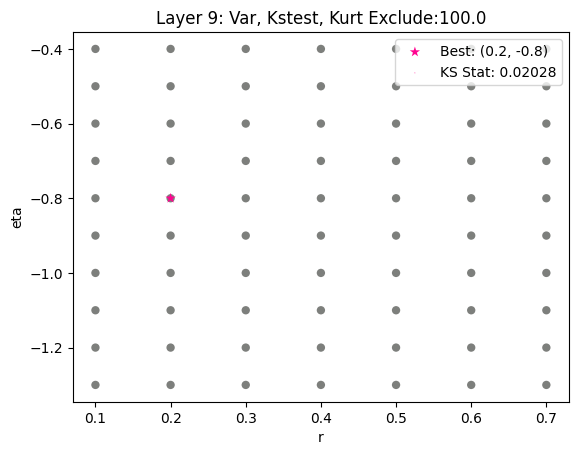

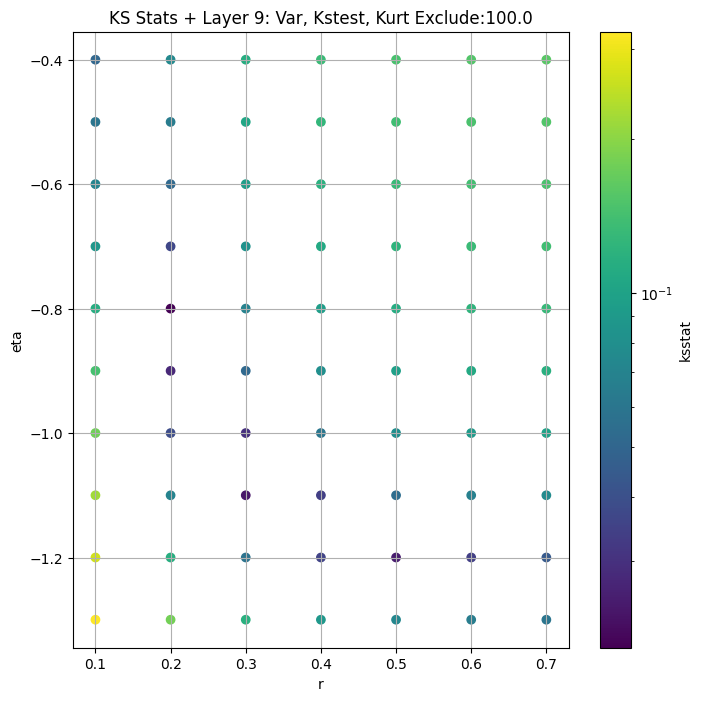

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1353.190300  1245.670900  1465.388900   0.434779    0.144766   
3       327.517880   311.696040   344.012240   1.583804    1.274782   
4        68.147350    63.903770    72.760056   4.318310    2.980371   
5        13.558892    12.578346    14.675803   6.925879    4.667317   
6         2.634974     2.408211     2.941564  12.295376    6.609304   
7         0.536970     0.482075     0.646513  28.076822    8.176512   
8         0.155016     0.136908     0.197966  46.127980    9.823513   
9         0.047454     0.041207     0.060932  54.854145   13.487100   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.749931         2446.0             0.014169        7.1          0.0   
3        1.950991         9784.0             0.006292        5.8         -0.8   
4        7.683027        39136.0             0.003905        2.0         -1.0   
5       16.993916       156544.0             0.004220        0.8         -1.0   
6       44.604836       626176.0             0.012167        0.7         -1.1   
7      160.379710      2504704.0             0.013424        1.0         -1.2   
8      257.993900     10018816.0             0.008484        0.5         -1.1   
9      273.324620     40075264.0             0.020276        0.2         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        2316.874390                     0.0         1353.190300   
3         835.049548                     0.0          327.517880   
4         201.625859                     0.0           68.147350   
5          20.400201                     0.0           13.558892   
6           4.106820                     0.0            2.634974   
7           1.692903                    25.0            0.507871   
8           0.093307                   100.0            0.134362   
9           0.000009                   100.0            0.040003   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.027391  
3                     0.013713  
4                     0.006861  
5                     0.003431  
6                     0.001716  
7                     0.000858  
8                     0.000429  
9                     0.000215

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/126 [00:00<?, ?it/s]

Finding Minimum after computing 126 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.06160113996646999, var: 849.5838012695312


  0%|          | 0/126 [00:00<?, ?it/s]

Finding Minimum after computing 126 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.05133400989251902, var: 931.08447265625


  0%|          | 0/126 [00:00<?, ?it/s]

Finding Minimum after computing 126 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.03983866892950971, var: 1031.261474609375


  0%|          | 0/126 [00:00<?, ?it/s]

Finding Minimum after computing 126 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02701378169792079, var: 1155.870849609375


  0%|          | 0/126 [00:00<?, ?it/s]

Finding Minimum after computing 126 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01416900310859981, var: 1353.1903076171875
Number of samples: 2446, Without approximation : 2446.0


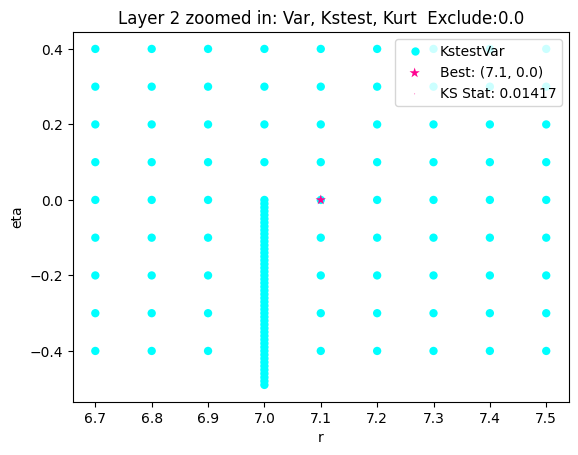

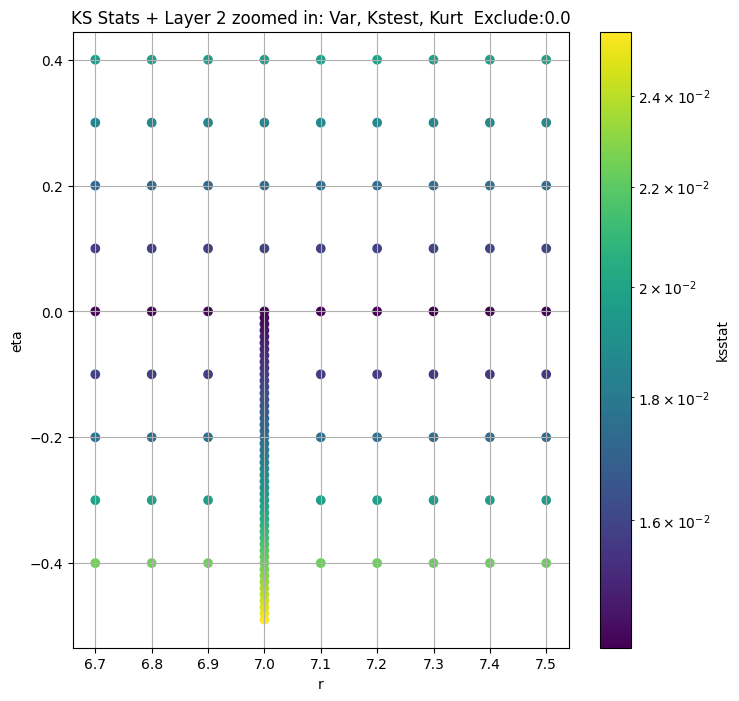

Layer 3


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.01725835899820538, var: 264.3583984375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.014320799118431204, var: 275.6953430175781


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.011758967099380735, var: 288.7802429199219


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.008805356609169812, var: 304.22119140625


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.006291815558071456, var: 327.51788330078125
Number of samples: 9784, Without approximation : 9784.0


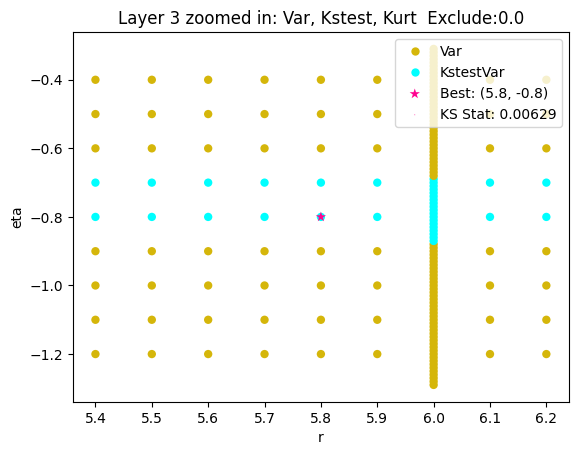

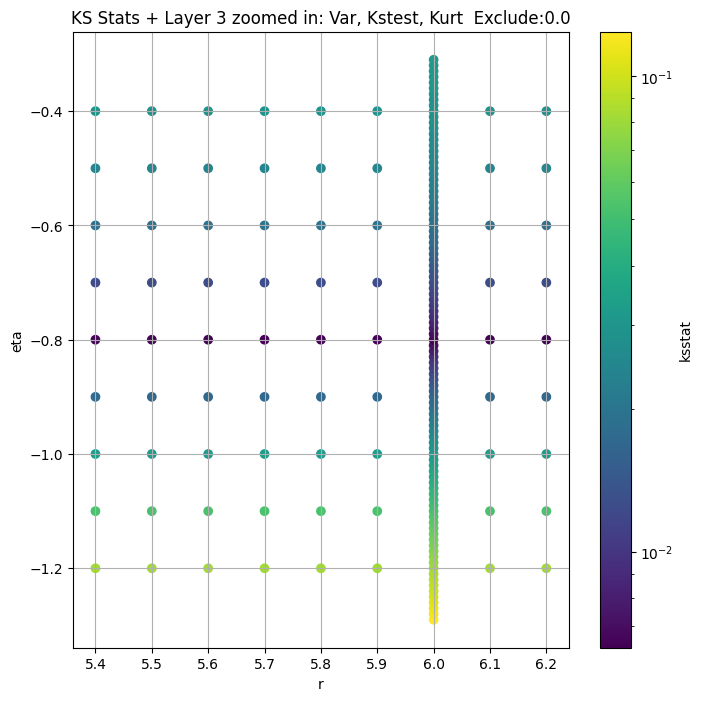

Layer 4


  0%|          | 0/916 [00:00<?, ?it/s]

Finding Minimum after computing 916 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.007127339770411134, var: 60.78388977050781


  0%|          | 0/916 [00:00<?, ?it/s]

Finding Minimum after computing 916 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006468180754766906, var: 62.04542541503906


  0%|          | 0/916 [00:00<?, ?it/s]

Finding Minimum after computing 916 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005867657814402849, var: 63.4699821472168


  0%|          | 0/916 [00:00<?, ?it/s]

Finding Minimum after computing 916 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.004037983040090398, var: 65.2270278930664


  0%|          | 0/916 [00:00<?, ?it/s]

Finding Minimum after computing 916 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0037376724740560974, var: 68.14734649658203
Number of samples: 39136, Without approximation : 39136.0


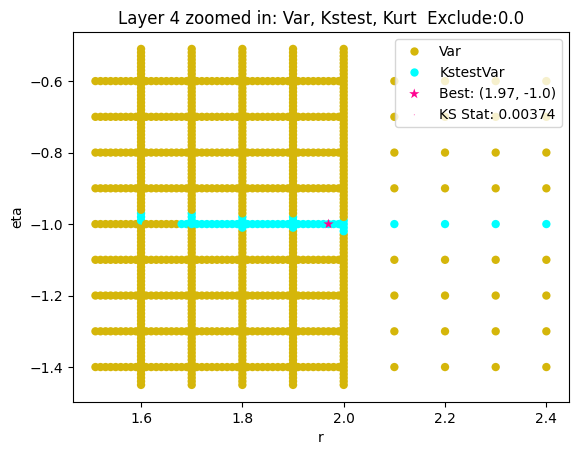

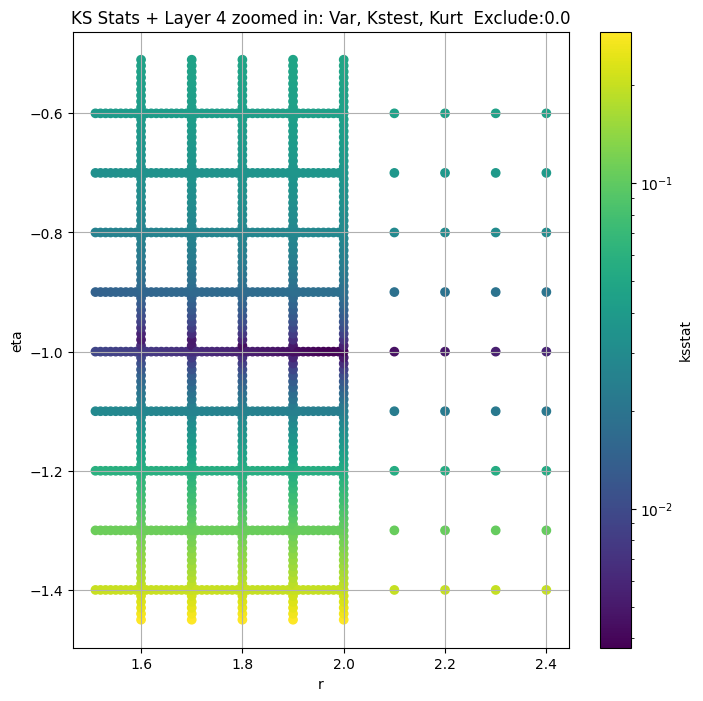

Layer 5


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.004623628165847271, var: 12.57225227355957


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.004277609743155164, var: 12.743633270263672


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.004029657261201913, var: 12.938088417053223


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0036057320543172455, var: 13.171043395996094


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0031150195181138818, var: 13.558892250061035
Number of samples: 100000, Without approximation : 156544.0


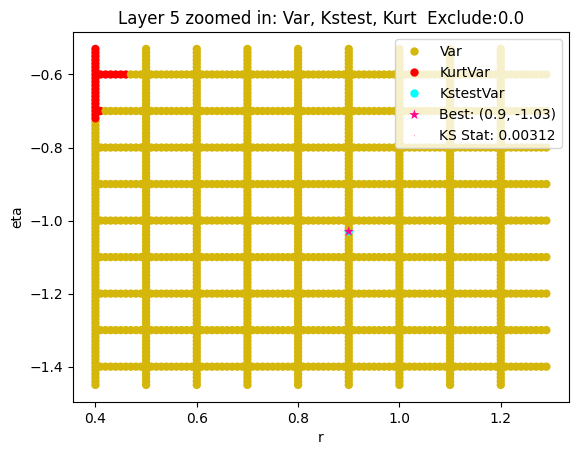

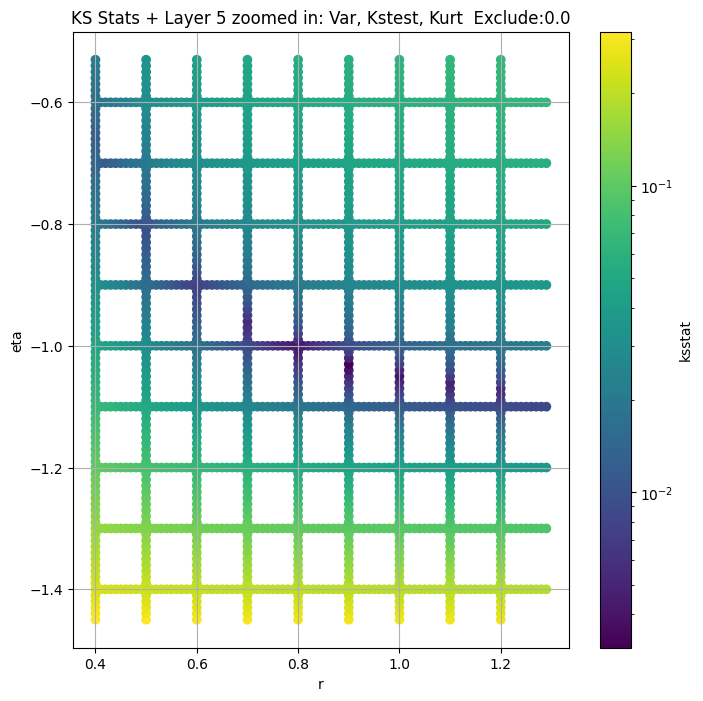

Layer 6


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.011512669409982468, var: 2.3867270946502686


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.011311970534645055, var: 2.427868604660034


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.011308610561361343, var: 2.4743733406066895


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.01116581396134575, var: 2.530236005783081


  0%|          | 0/1570 [00:00<?, ?it/s]

Finding Minimum after computing 1570 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.01109399127548838, var: 2.6349737644195557
Number of samples: 100000, Without approximation : 626176.0


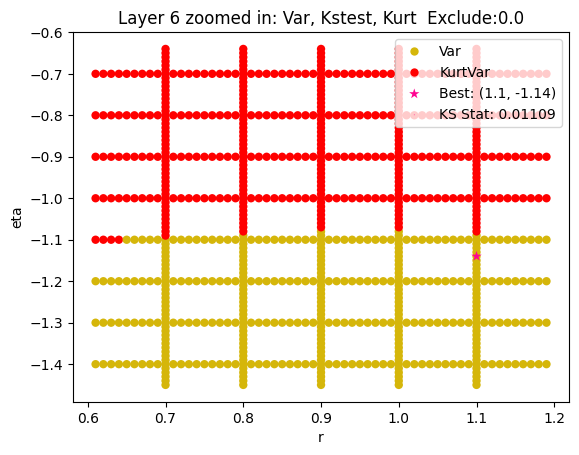

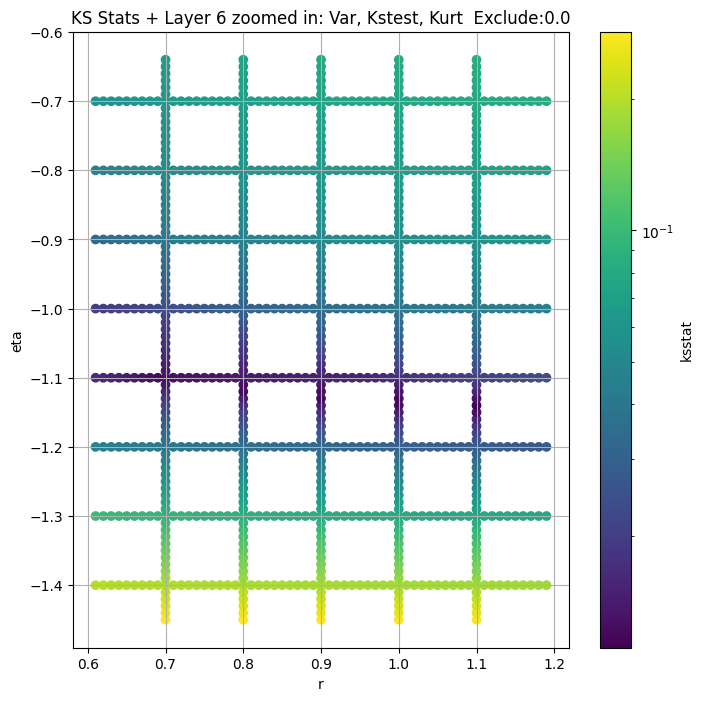

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.012914493297838447, var: 0.46662601828575134


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.012740611320612216, var: 0.47493118047714233


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.012787674972723151, var: 0.48417773842811584


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.01308953424731063, var: 0.4948417842388153


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.012680008750309113, var: 0.5078710317611694


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.011799940645487672, var: 0.5369695425033569
Number of samples: 100000, Without approximation : 2504704.0


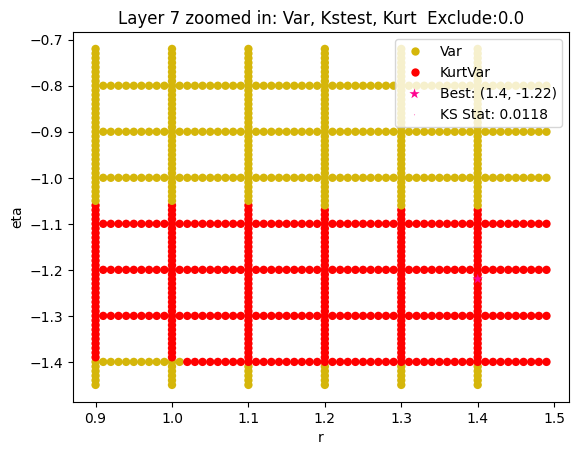

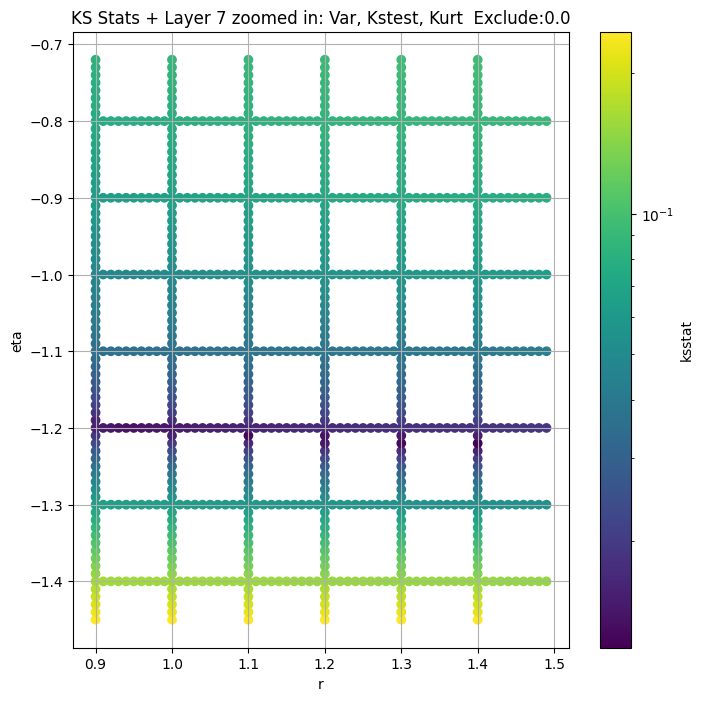

Layer 8


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + 100 = 200, ksstat: 0.007694355541362628, var: 0.1250426471233368


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + 75 = 175, ksstat: 0.00745734133922038, var: 0.1271165907382965


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + 50 = 150, ksstat: 0.006722212621649723, var: 0.12933789193630219


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + 25 = 125, ksstat: 0.00657970221025983, var: 0.13173650205135345


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + 0 = 100, ksstat: 0.006445862829972948, var: 0.134362131357193


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + -25 = 75, ksstat: 0.006964518903283479, var: 0.1372891217470169


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + -50 = 50, ksstat: 0.0071545907053684465, var: 0.1406598836183548


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + -75 = 25, ksstat: 0.006065256608805969, var: 0.14478690922260284


  0%|          | 0/1477 [00:00<?, ?it/s]

Finding Minimum after computing 1477 CDFs
layer 8, 100.0 + -100 = 0, ksstat: 0.006490441335779473, var: 0.15501633286476135
Number of samples: 100000, Without approximation : 10018816.0


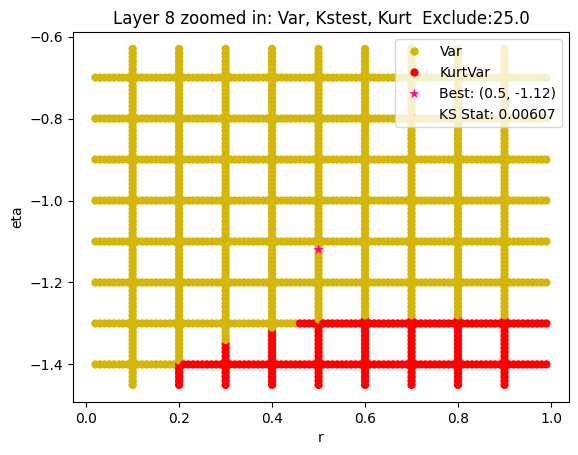

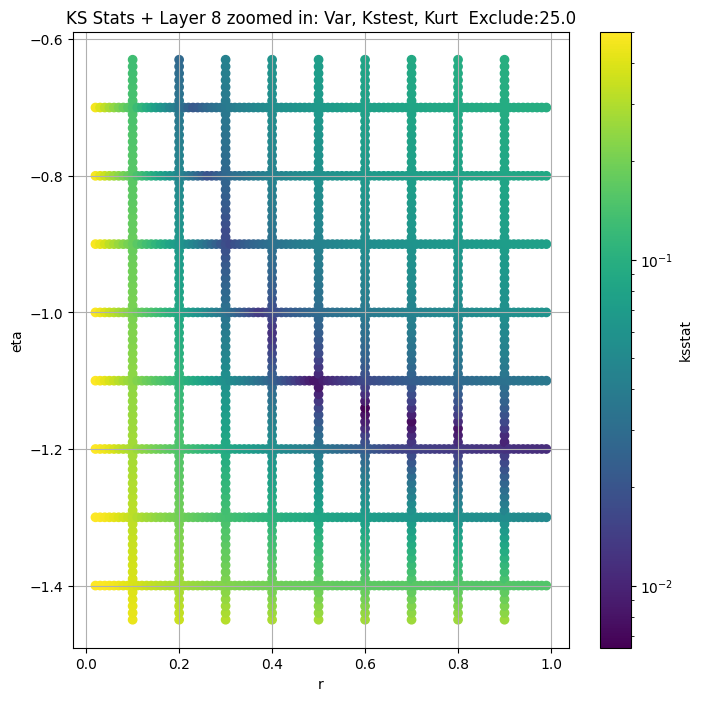

Layer 9


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + 100 = 200, ksstat: 0.016473300443892447, var: 0.03666681796312332


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + 75 = 175, ksstat: 0.016645499787244666, var: 0.037404101341962814


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + 50 = 150, ksstat: 0.016774169947151307, var: 0.03819694370031357


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + 25 = 125, ksstat: 0.015892875517659832, var: 0.039057184010744095


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + 0 = 100, ksstat: 0.015699830350592636, var: 0.04000313580036163


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + -25 = 75, ksstat: 0.01503734653949429, var: 0.04106210544705391


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + -50 = 50, ksstat: 0.016245188319317205, var: 0.042288098484277725


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + -75 = 25, ksstat: 0.015816422969231136, var: 0.04380076378583908


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
layer 9, 100.0 + -100 = 0, ksstat: 0.014317834334712787, var: 0.04745376110076904
Number of samples: 100000, Without approximation : 40075264.0


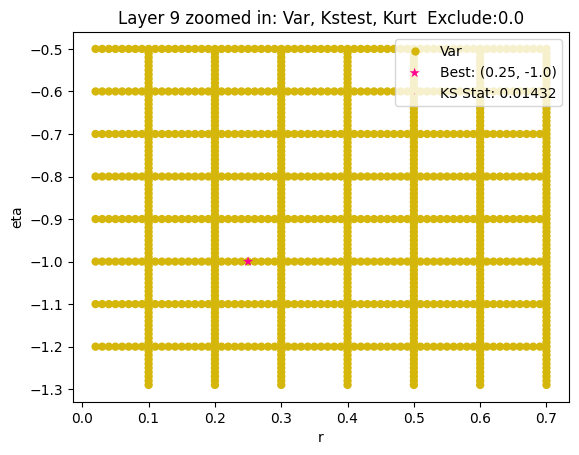

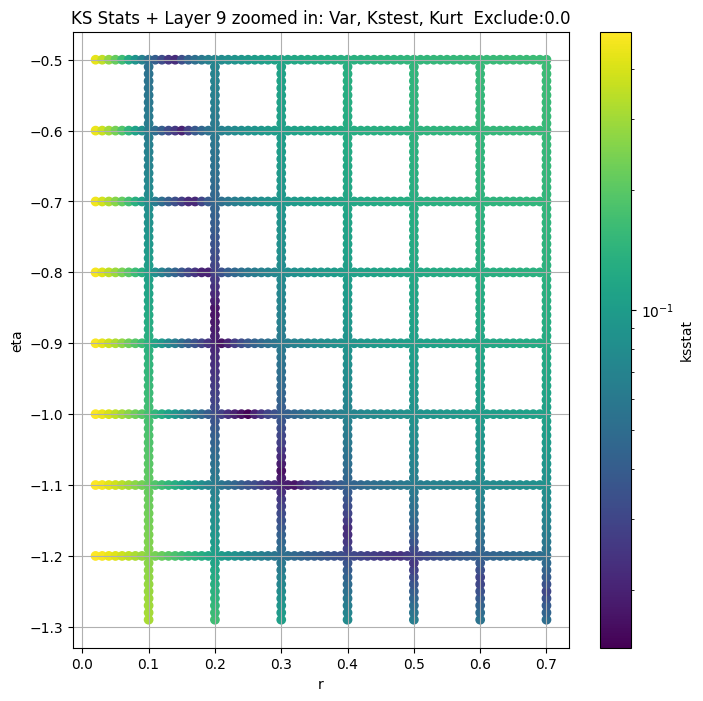

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1353.190300  1245.670900  1465.388900   0.434779    0.144766   
3       327.517880   311.696040   344.012240   1.583804    1.274782   
4        68.147350    63.903770    72.760056   4.318310    2.980371   
5        13.558892    12.578346    14.675803   6.925879    4.667317   
6         2.634974     2.408211     2.941564  12.295376    6.609304   
7         0.536970     0.482075     0.646513  28.076822    8.176512   
8         0.155016     0.136908     0.197966  46.127980    9.823513   
9         0.047454     0.041207     0.060932  54.854145   13.487100   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.749931         2446.0             0.014169        7.1          0.0   
3        1.950991         9784.0             0.006292        5.8         -0.8   
4        7.683027        39136.0             0.003905        2.0         -1.0   
5       16.993916       156544.0             0.004220        0.8         -1.0   
6       44.604836       626176.0             0.012167        0.7         -1.1   
7      160.379710      2504704.0             0.013424        1.0         -1.2   
8      257.993900     10018816.0             0.008484        0.5         -1.1   
9      273.324620     40075264.0             0.020276        0.2         -0.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        2316.874390                     0.0         1353.190300   
3         835.049548                     0.0          327.517880   
4         201.625859                     0.0           68.147346   
5          20.400201                     0.0           13.558892   
6           4.106820                     0.0            2.634974   
7           1.692903                    25.0            0.536970   
8           0.093307                   100.0            0.144787   
9           0.000009                   100.0            0.047454   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.027391          0.014169    7.10      0.00   
3                     0.013713          0.006292    5.80     -0.80   
4                     0.006861          0.003738    1.97     -1.00   
5                     0.003431          0.003115    0.90     -1.03   
6                     0.001716          0.011094    1.10     -1.14   
7                     0.000858          0.011800    1.40     -1.22   
8                     0.000429          0.006065    0.50     -1.12   
9                     0.000215          0.014318    0.25     -1.00   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      2316.874390                  0.0         9285  
3       835.049548                  0.0        47013  
4       200.874505                  0.0       132084  
5        25.658636                  0.0       198126  
6         7.913116                  0.0        14676  
7         2.331388                  0.0        13929  
8         0.108244                 25.0        49531  
9         0.000395                  0.0         9285

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

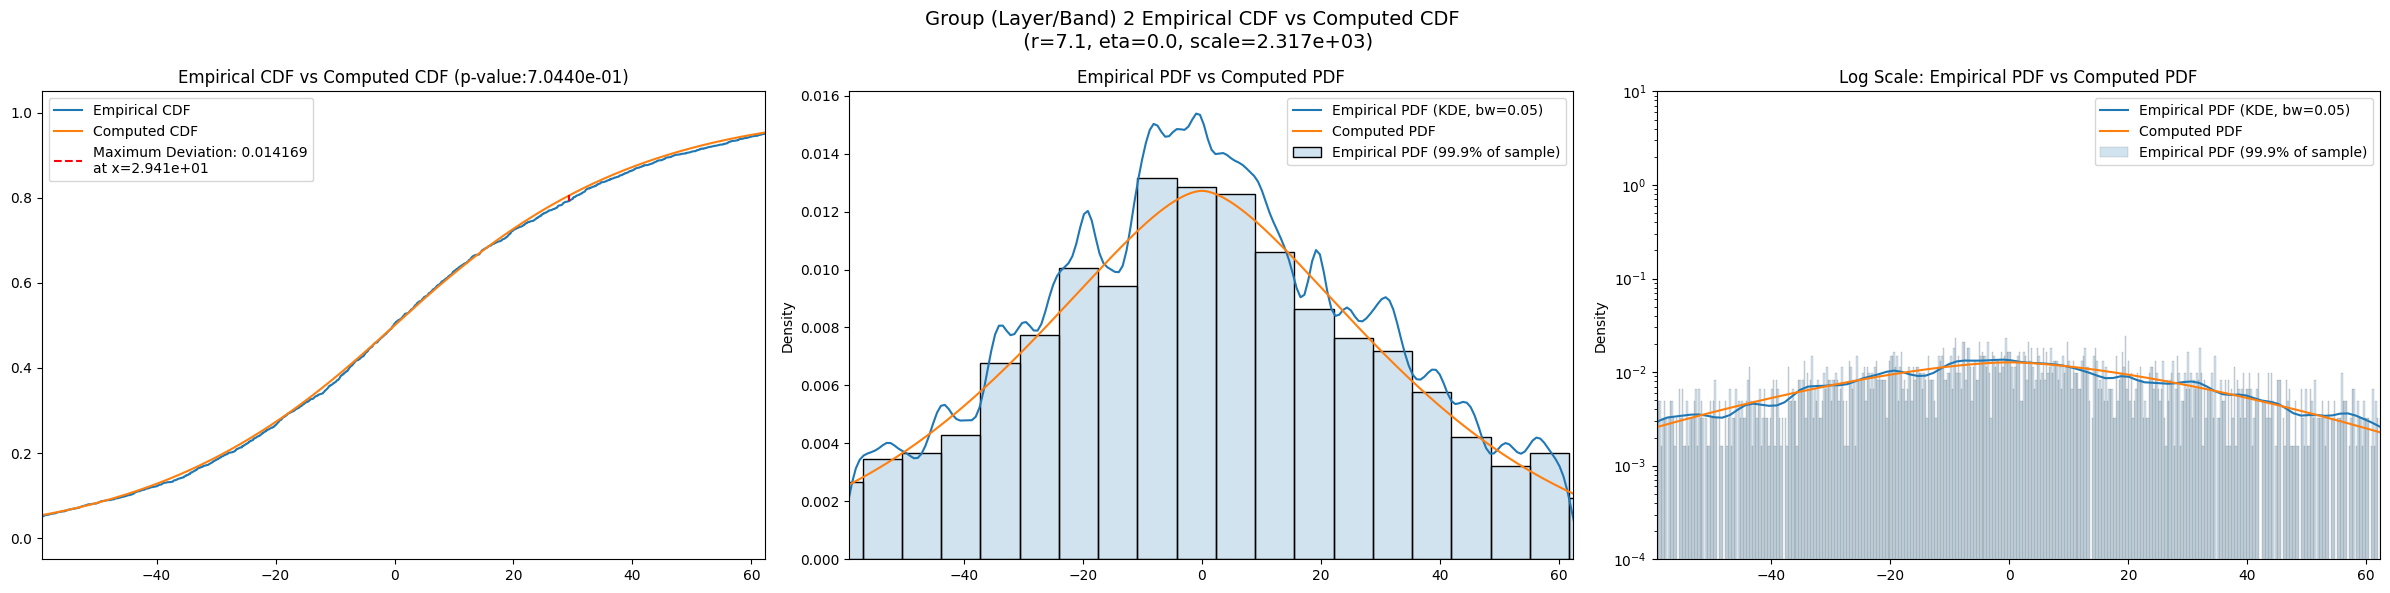

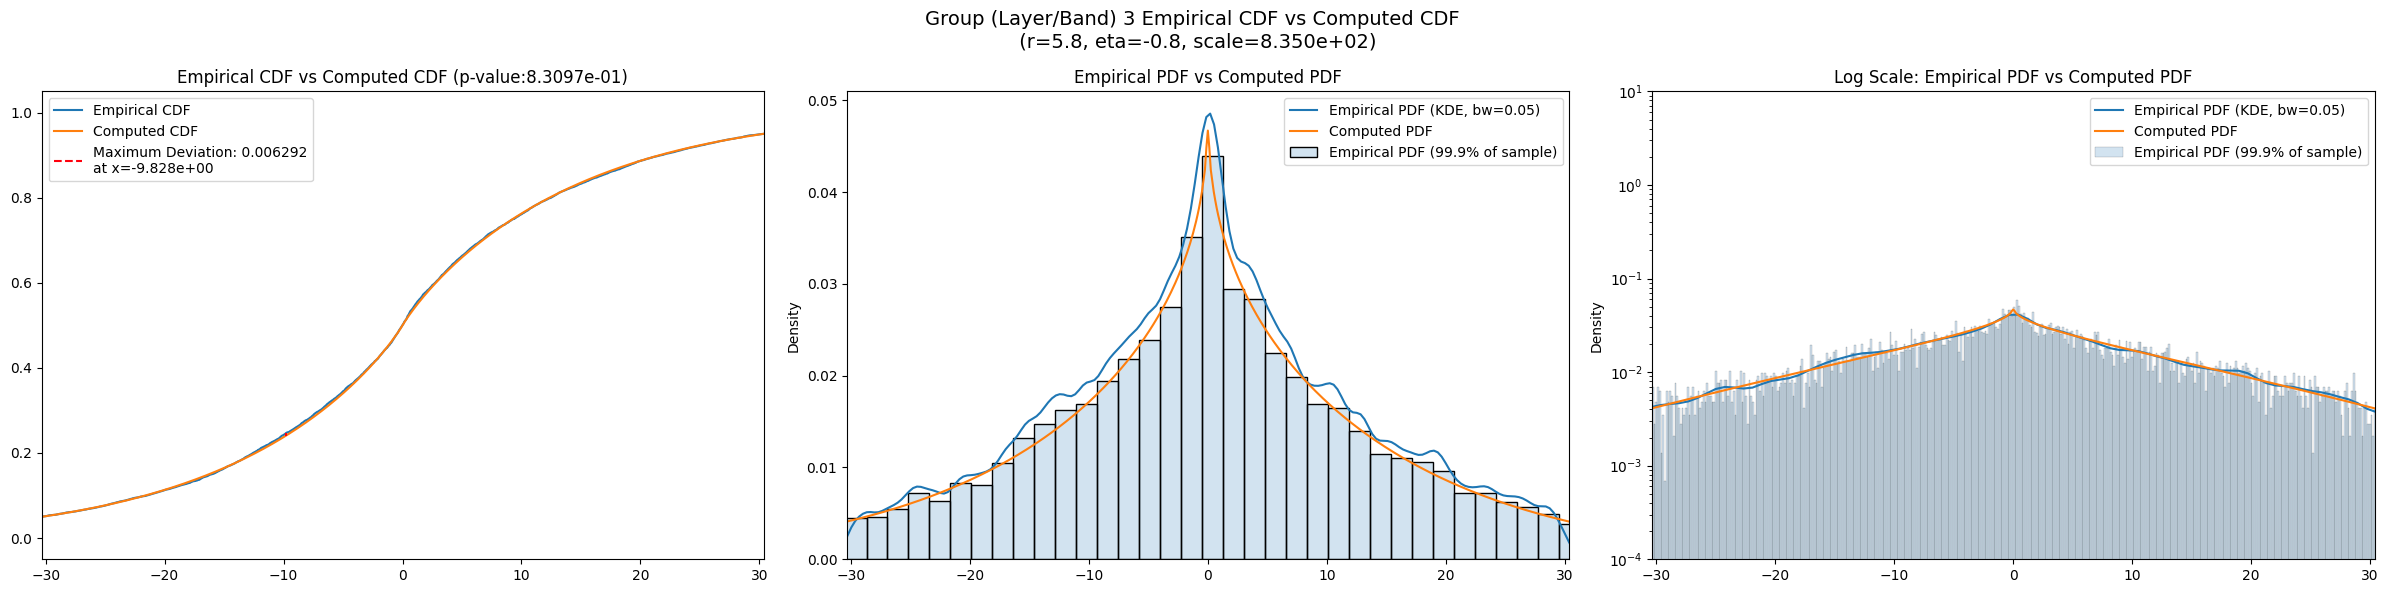

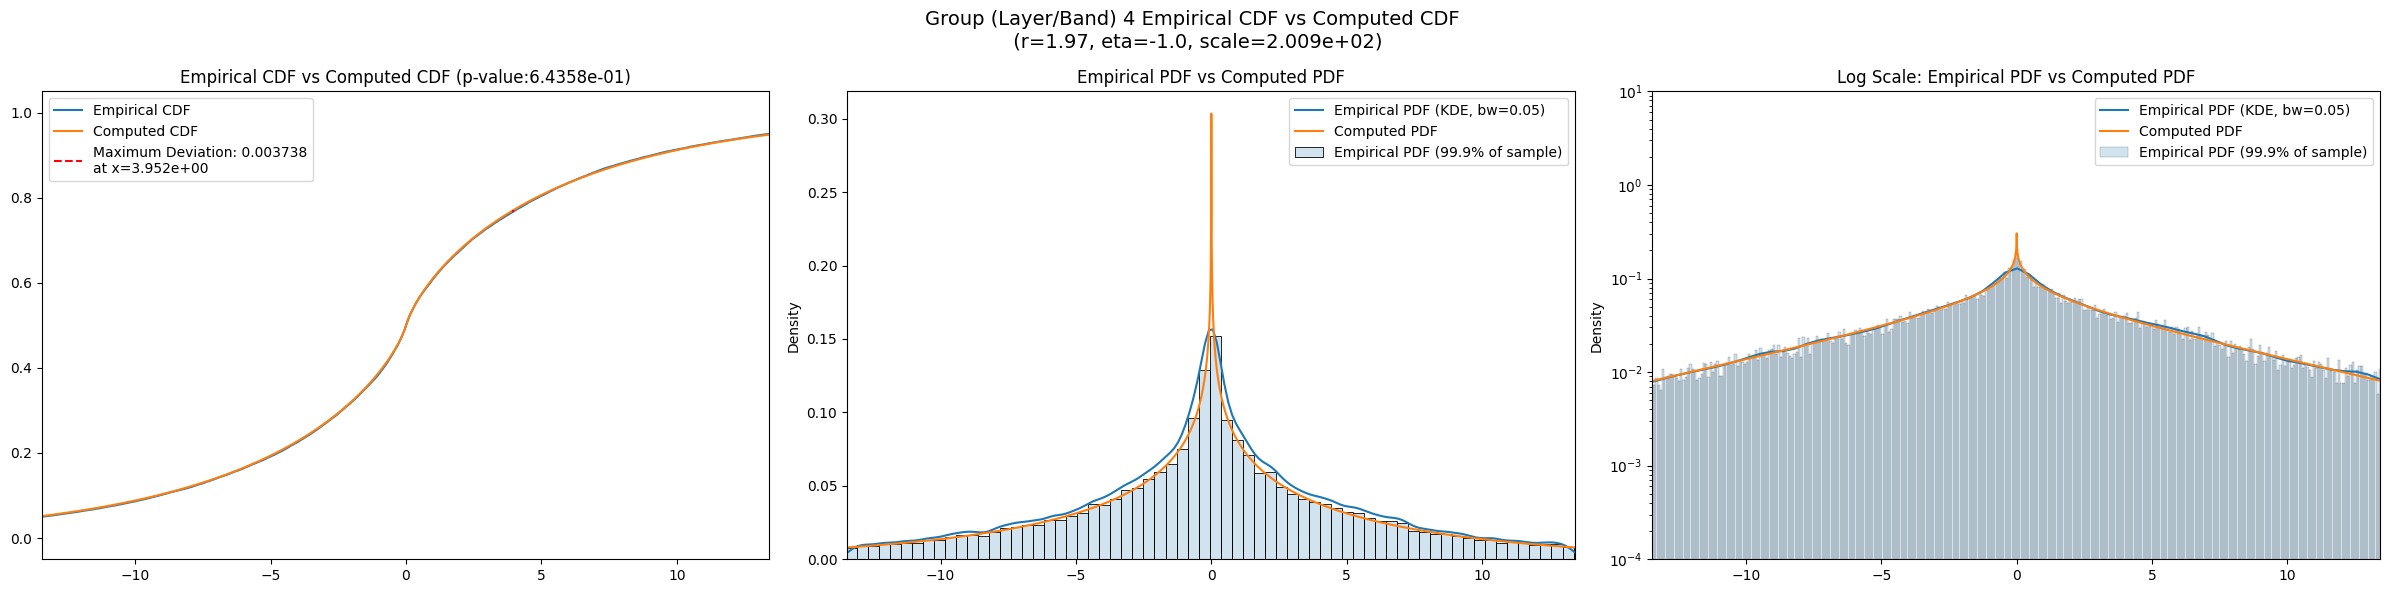

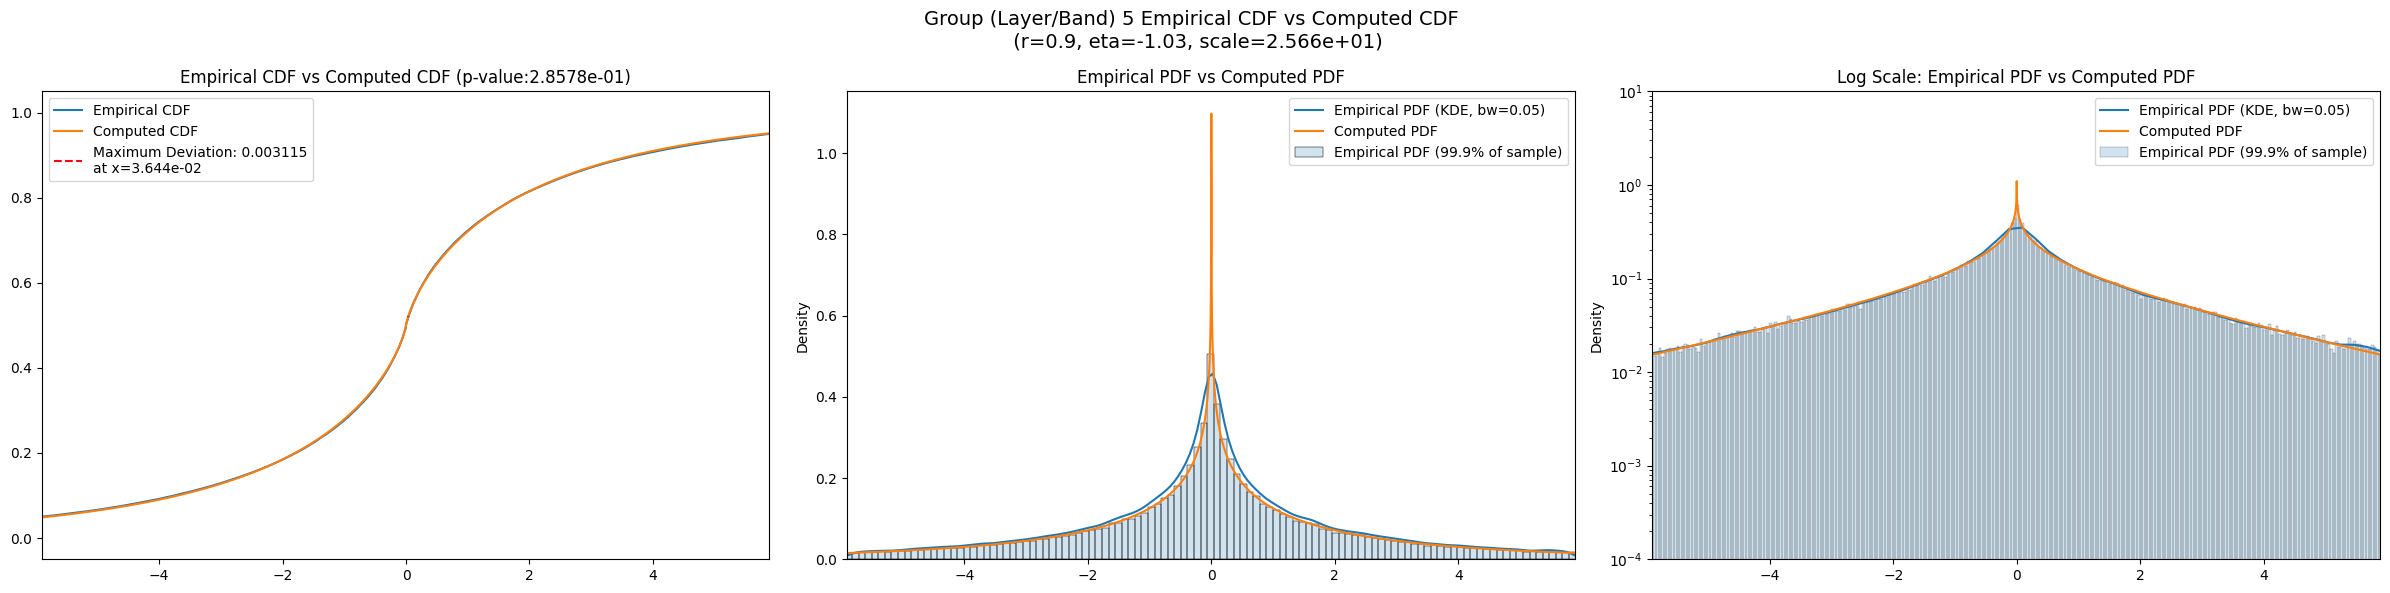

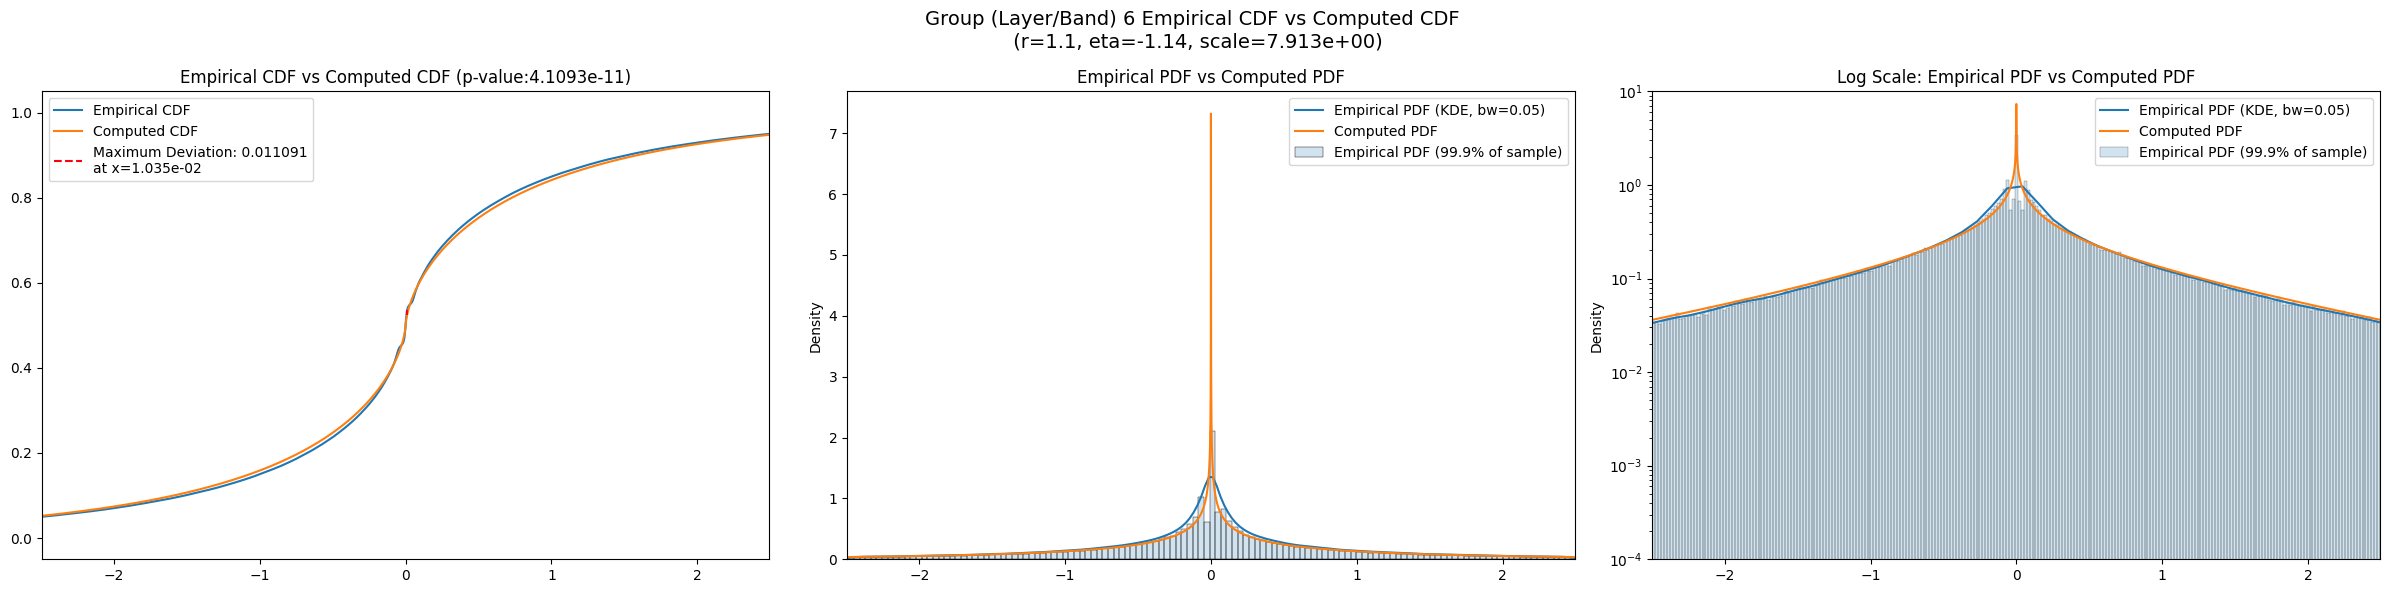

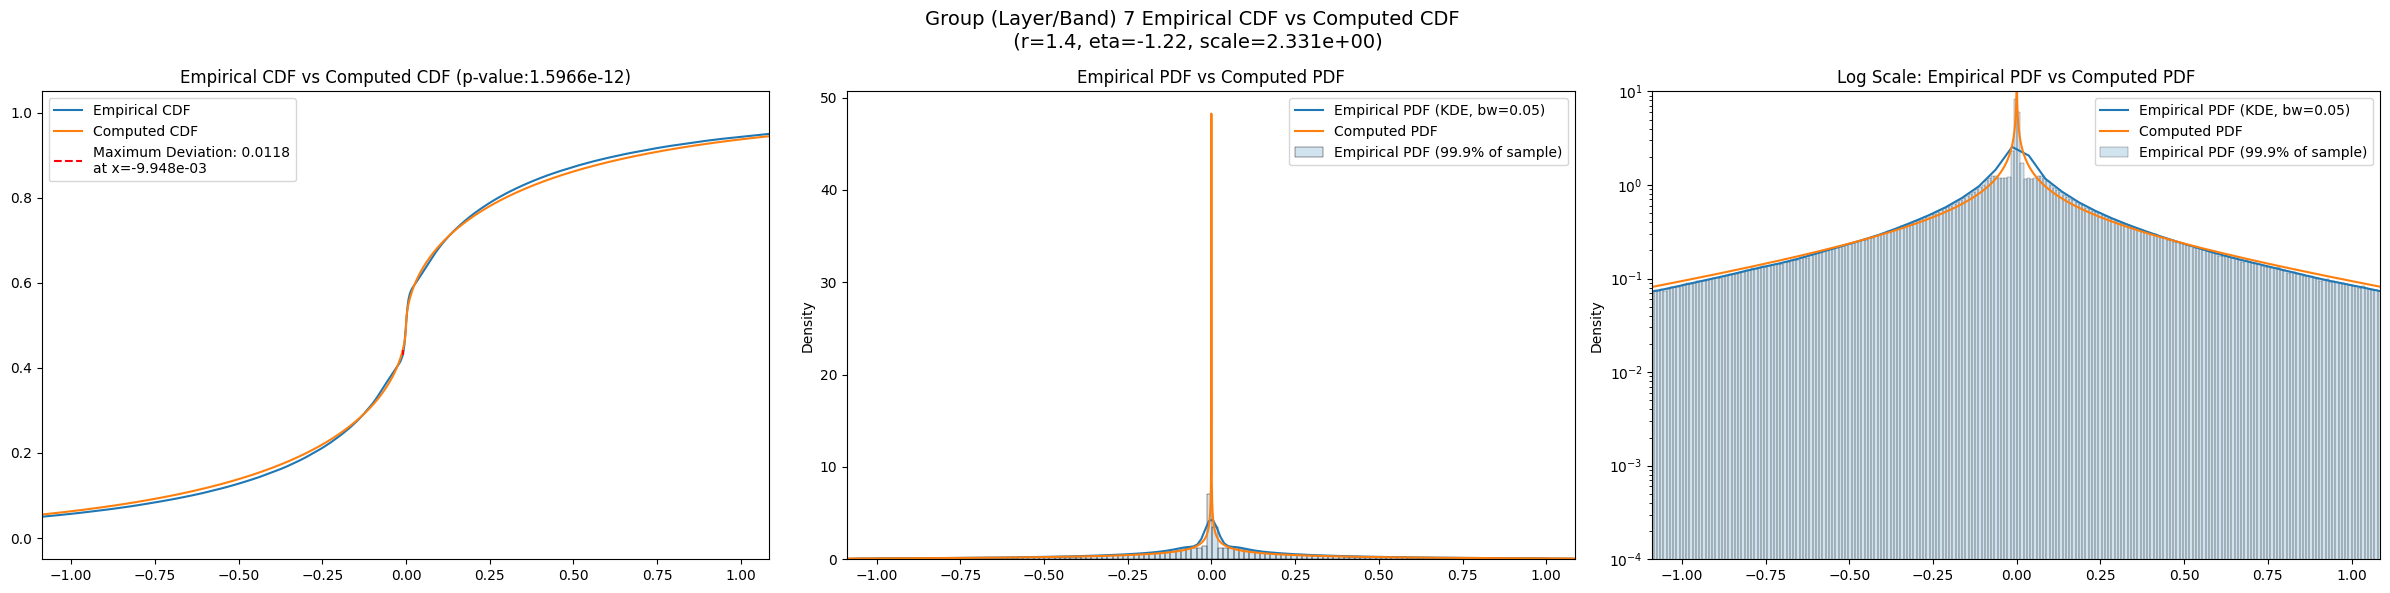

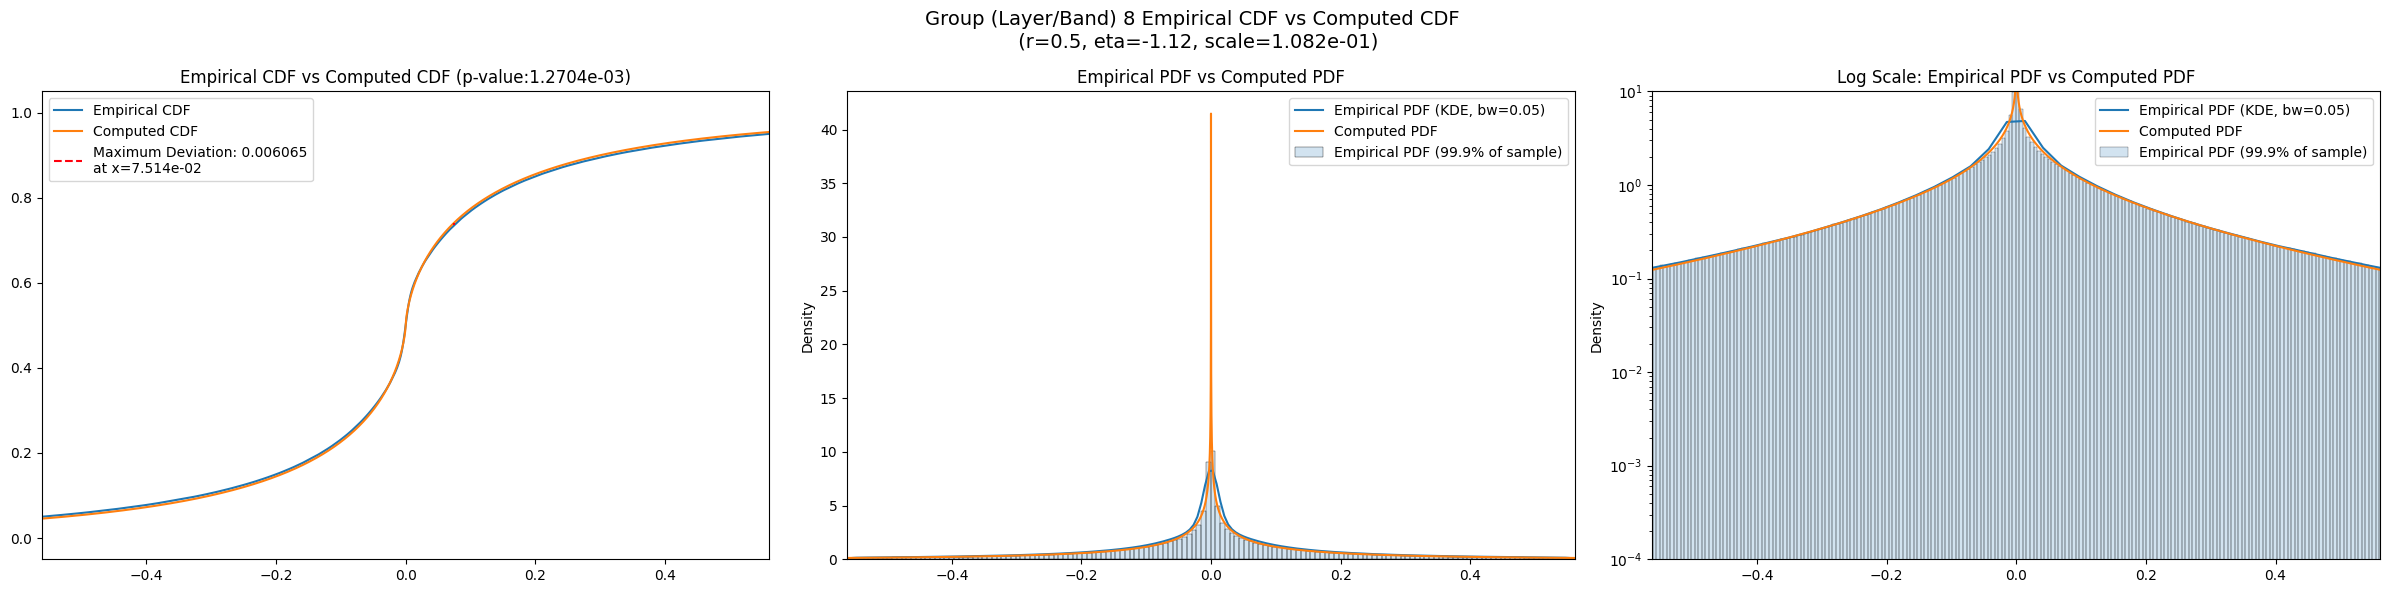

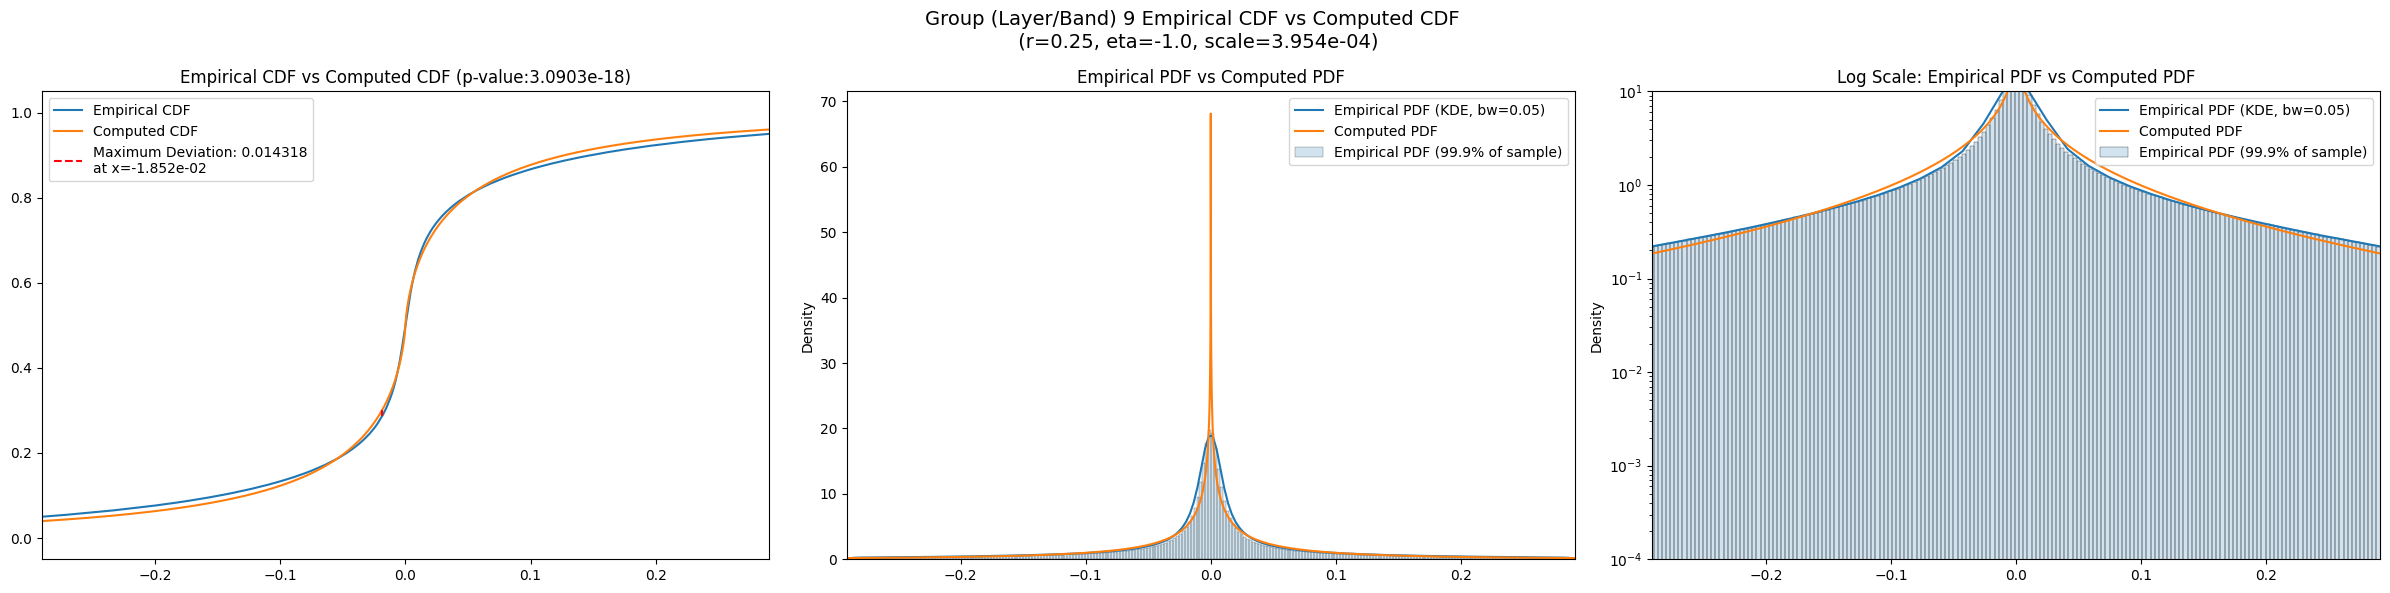

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1353.190300  1245.670900  1465.388900   0.434779    0.144766   
3       327.517880   311.696040   344.012240   1.583804    1.274782   
4        68.147350    63.903770    72.760056   4.318310    2.980371   
5        13.558892    12.578346    14.675803   6.925879    4.667317   
6         2.634974     2.408211     2.941564  12.295376    6.609304   
7         0.536970     0.482075     0.646513  28.076822    8.176512   
8         0.155016     0.136908     0.197966  46.127980    9.823513   
9         0.047454     0.041207     0.060932  54.854145   13.487100   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.749931         2446.0             0.014169        7.1          0.0   
3        1.950991         9784.0             0.006292        5.8         -0.8   
4        7.683027        39136.0             0.003905        2.0         -1.0   
5       16.993916       156544.0             0.004220        0.8         -1.0   
6       44.604836       626176.0             0.012167        0.7         -1.1   
7      160.379710      2504704.0             0.013424        1.0         -1.2   
8      257.993900     10018816.0             0.008484        0.5         -1.1   
9      273.324620     40075264.0             0.020276        0.2         -0.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       34.291000              0.022359          1.706590e-01   
3      ...       14.885700              0.032248          2.832030e-09   
4      ...        5.780670              0.046799          6.344440e-75   
5      ...        2.212730              0.058466          0.000000e+00   
6      ...        0.826302              0.068146          0.000000e+00   
7      ...        0.344378              0.070048          0.000000e+00   
8      ...        0.160305              0.076614          0.000000e+00   
9      ...        0.060872              0.095066          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          30.581900             0.023871         1.211480e-01  25.291900   
3          13.088600             0.010542         2.253750e-01  10.934400   
4           4.916940             0.022610         8.209350e-18   4.036670   
5           1.901540             0.032359        7.578740e-143   1.520490   
6           0.707008             0.042686         0.000000e+00   0.561201   
7           0.267578             0.054754         0.000000e+00   0.212045   
8           0.134170             0.053832         0.000000e+00   0.104206   
9           0.053157             0.069836         0.000000e+00   0.040832   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.028479   3.710970e-02          7.044105e-01  
3           0.016864   7.572080e-03          8.309659e-01  
4           0.028334   9.969930e-28          6.435850e-01  
5           0.035989  1.335450e-176          9.565163e-02  
6           0.045543   0.000000e+00          2.269391e-67  
7           0.057023   0.000000e+00                   NaN  
8           0.056007   0.000000e+00                   NaN  
9           0.068675   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.014169                 0.027391          0.014169   
3                 0.006292                 0.013713          0.006292   
4                 0.003905                 0.006861          0.003738   
5                 0.004220                 0.003431          0.003115   
6                 0.012167                 0.001716          0.011094   
7                 0.013424                 0.000858          0.011800   
8                 0.008484                 0.000429          0.006065   
9                 0.020276                 0.000215          0.014318   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.022359             0.023871       0.028479  
3                  0.032248             0.010542       0.016864  
4                  0.046799             0.022610       0.028334  
5                  0.058466             0.032359       0.035989  
6                  0.068146             0.042686       0.045543  
7                  0.070048             0.054754       0.057023  
8                  0.076614             0.053832       0.056007  
9                  0.095066             0.069836       0.068675

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             1353.190300          0.014169    7.10      0.00  2316.874390   
3              327.517880          0.006292    5.80     -0.80   835.049548   
4               68.147346          0.003738    1.97     -1.00   200.874505   
5               13.558892          0.003115    0.90     -1.03    25.658636   
6                2.634974          0.011094    1.10     -1.14     7.913116   
7                0.536970          0.011800    1.40     -1.22     2.331388   
8                0.144787          0.006065    0.50     -1.12     0.108244   
9                0.047454          0.014318    0.25     -1.00     0.000395   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                     25.0  
9                      0.0

In [21]:
eng.quit()